In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from utils import replace_relu_with_qcfs, replace_qcfs_with_sn
from modules import reset_net
import matplotlib.pyplot as plt
import copy
import numpy as np
from funcs import seed_all
from tqdm.notebook import tqdm
seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

N = 16
B = 256
V_T = 1
TAU = 4
T = 8
DT = 0.001
SIGMA = 10

TIMESTEPS = int(T / DT)
TIME = np.arange(1, TIMESTEPS + 1) * DT
print(f'Simulating {TIMESTEPS} timesteps')

2024-11-12 08:35:00.861463: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 08:35:00.880900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


42
Simulating 8000 timesteps


In [2]:
W, BIAS = torch.rand((N, N)) / N, torch.randn(N)
net = nn.Sequential(nn.ReLU(), nn.Linear(N, N), nn.ReLU())
with torch.no_grad():
	net[1].weight = torch.nn.Parameter(W)
	net[1].bias = torch.nn.Parameter(BIAS)
def make_model():
	return copy.deepcopy(net)

X = torch.rand(size=(B, N)) * 0.1
Y = make_model()(X).cpu()

def run_exp(model: nn.Module):
	reset_net(model)
	loss_fn = nn.MSELoss()
	loss_fn_per_sample = nn.MSELoss(reduction='none')
	loss_mean = []
	loss_var = []
	spikes_history = []
	spikes_sum = torch.zeros_like(Y)
	for t in tqdm(TIME):
		spikes_sum += model(X)
		activation = spikes_sum / t
		loss_val = loss_fn(activation, Y).mean(dim=0).detach().item()
		loss_per_sample = loss_fn_per_sample(activation, Y)
		loss_mean.append(loss_val)
		loss_var.append(loss_per_sample.var(dim=1).detach().numpy())
		spikes_history.append(model[-1].spikes.int())
	return np.array(loss_mean), np.array(loss_var), torch.stack(spikes_history)

In [3]:
model = make_model()
model = replace_relu_with_qcfs(model, L=V_T)
model = replace_qcfs_with_sn(model, TAU, "if", noise=SIGMA, dt=DT)
loss_mean_if, loss_var_if, _ = run_exp(model)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [4]:
model = make_model()
model = replace_relu_with_qcfs(model, L=V_T)
model = replace_qcfs_with_sn(model, TAU, "gn", noise=SIGMA, dt=DT)
loss_mean_gn, loss_var_gn, _ = run_exp(model)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [5]:
model = make_model()
model = replace_relu_with_qcfs(model, L=V_T)
model = replace_qcfs_with_sn(model, TAU, "pgn", noise=SIGMA, dt=DT)
loss_mean_pgn, loss_var_pgn, _ = run_exp(model)

  0%|          | 0/8000 [00:00<?, ?it/s]

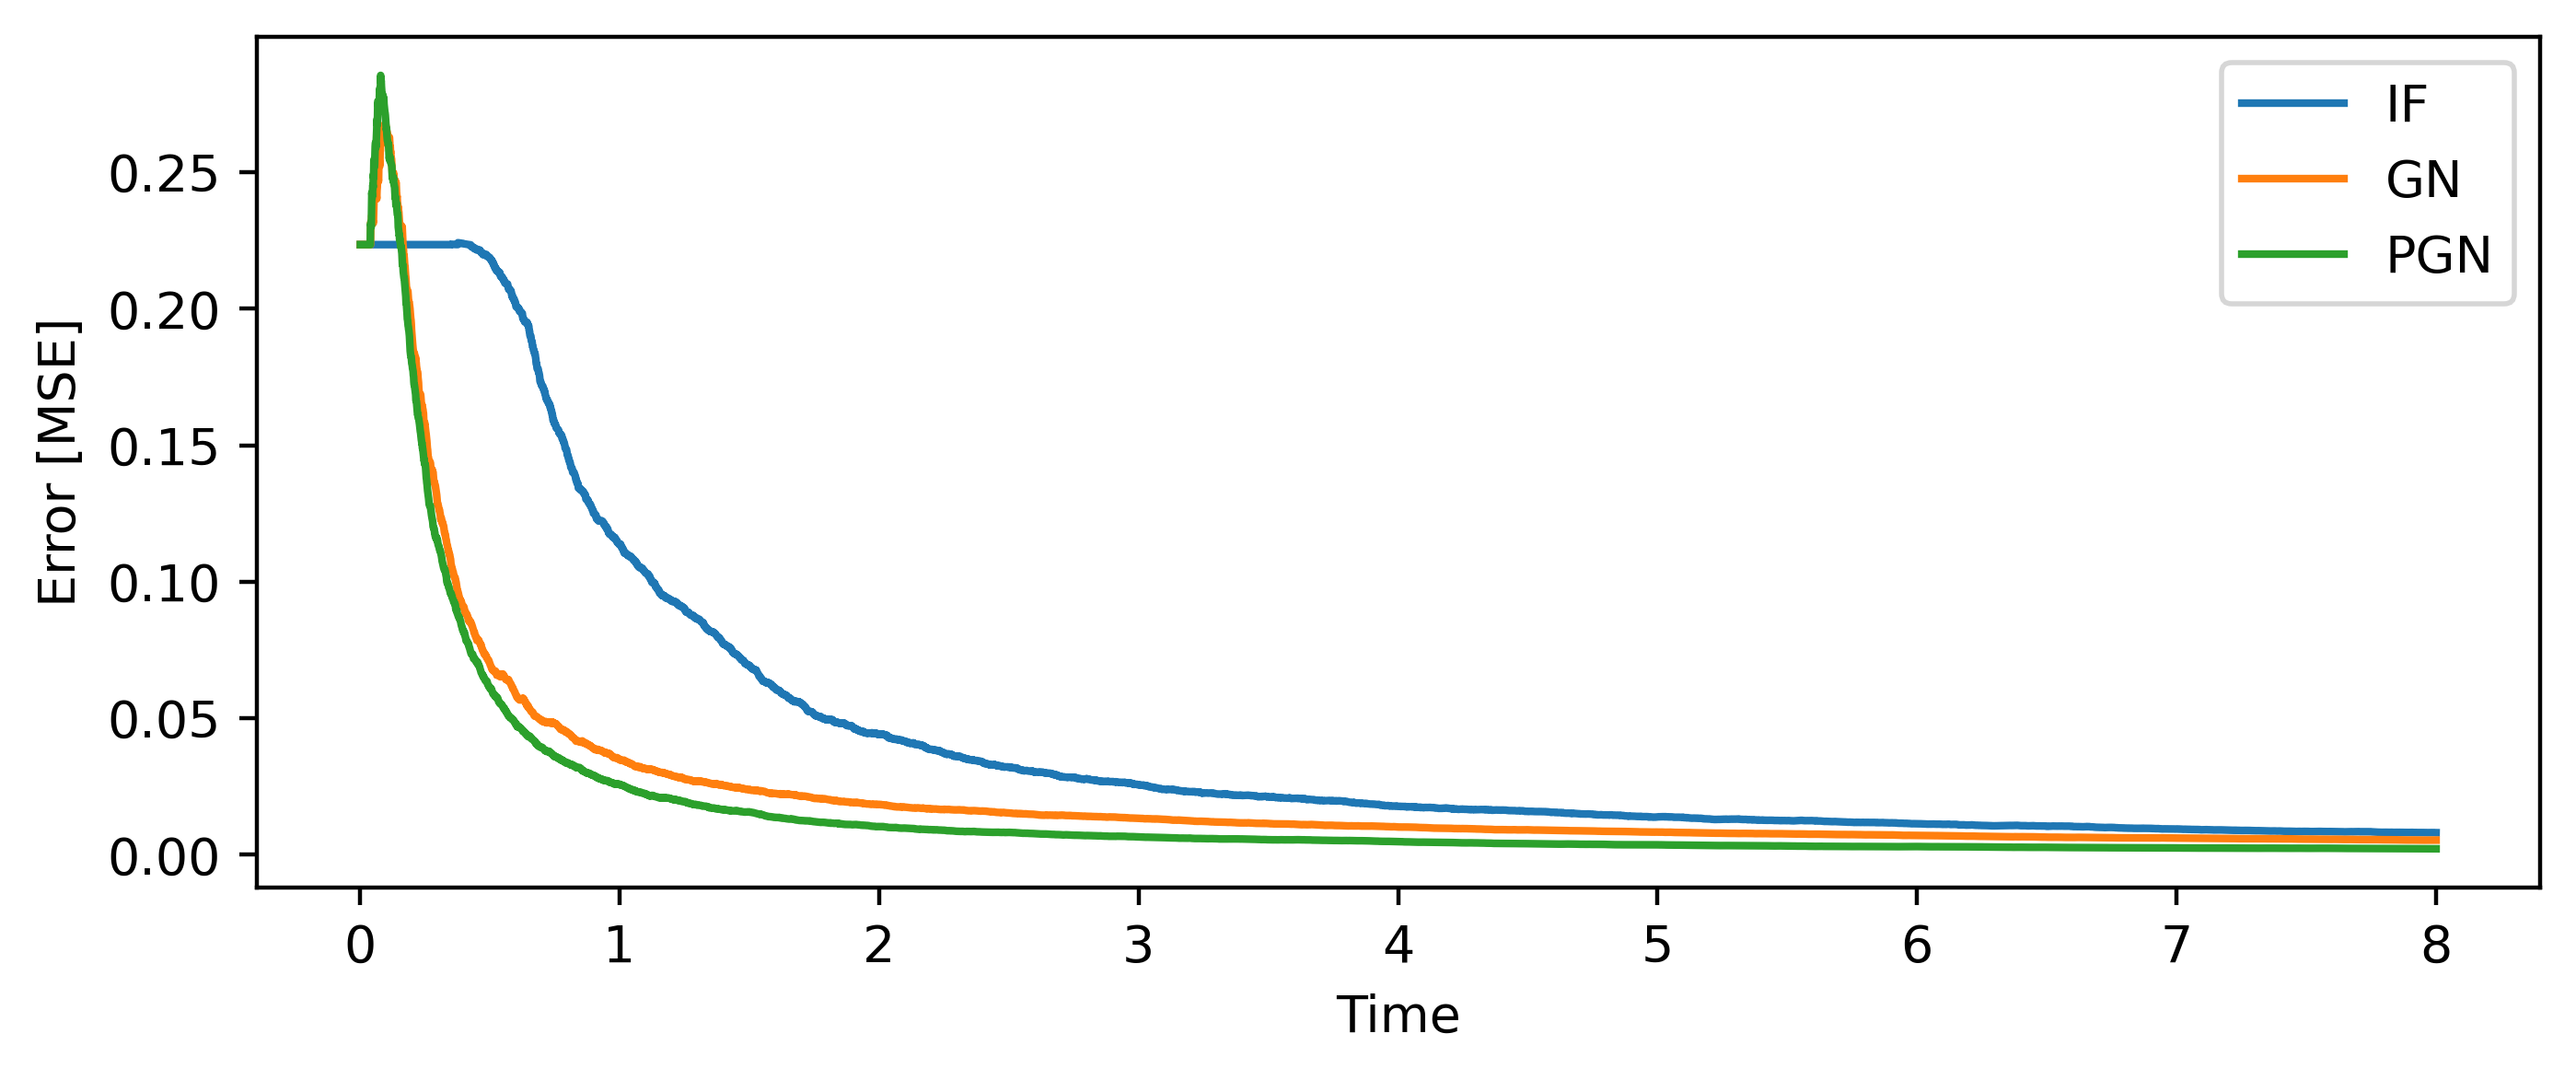

In [6]:
plt.figure(figsize=(8, 3), dpi=400)
plt.plot(TIME, loss_mean_if, label='IF', color='C0')
plt.plot(TIME, loss_mean_gn, label='GN', color='C1')
plt.plot(TIME, loss_mean_pgn, label='PGN', color='C2')
plt.ylabel('Error [MSE]')
plt.xlabel('Time')
plt.legend();

  0%|          | 0/5 [00:00<?, ?it/s]

0.11979885399341583


  0%|          | 0/50 [00:00<?, ?it/s]

0.22349926829338074


  0%|          | 0/500 [00:00<?, ?it/s]

0.22349926829338074


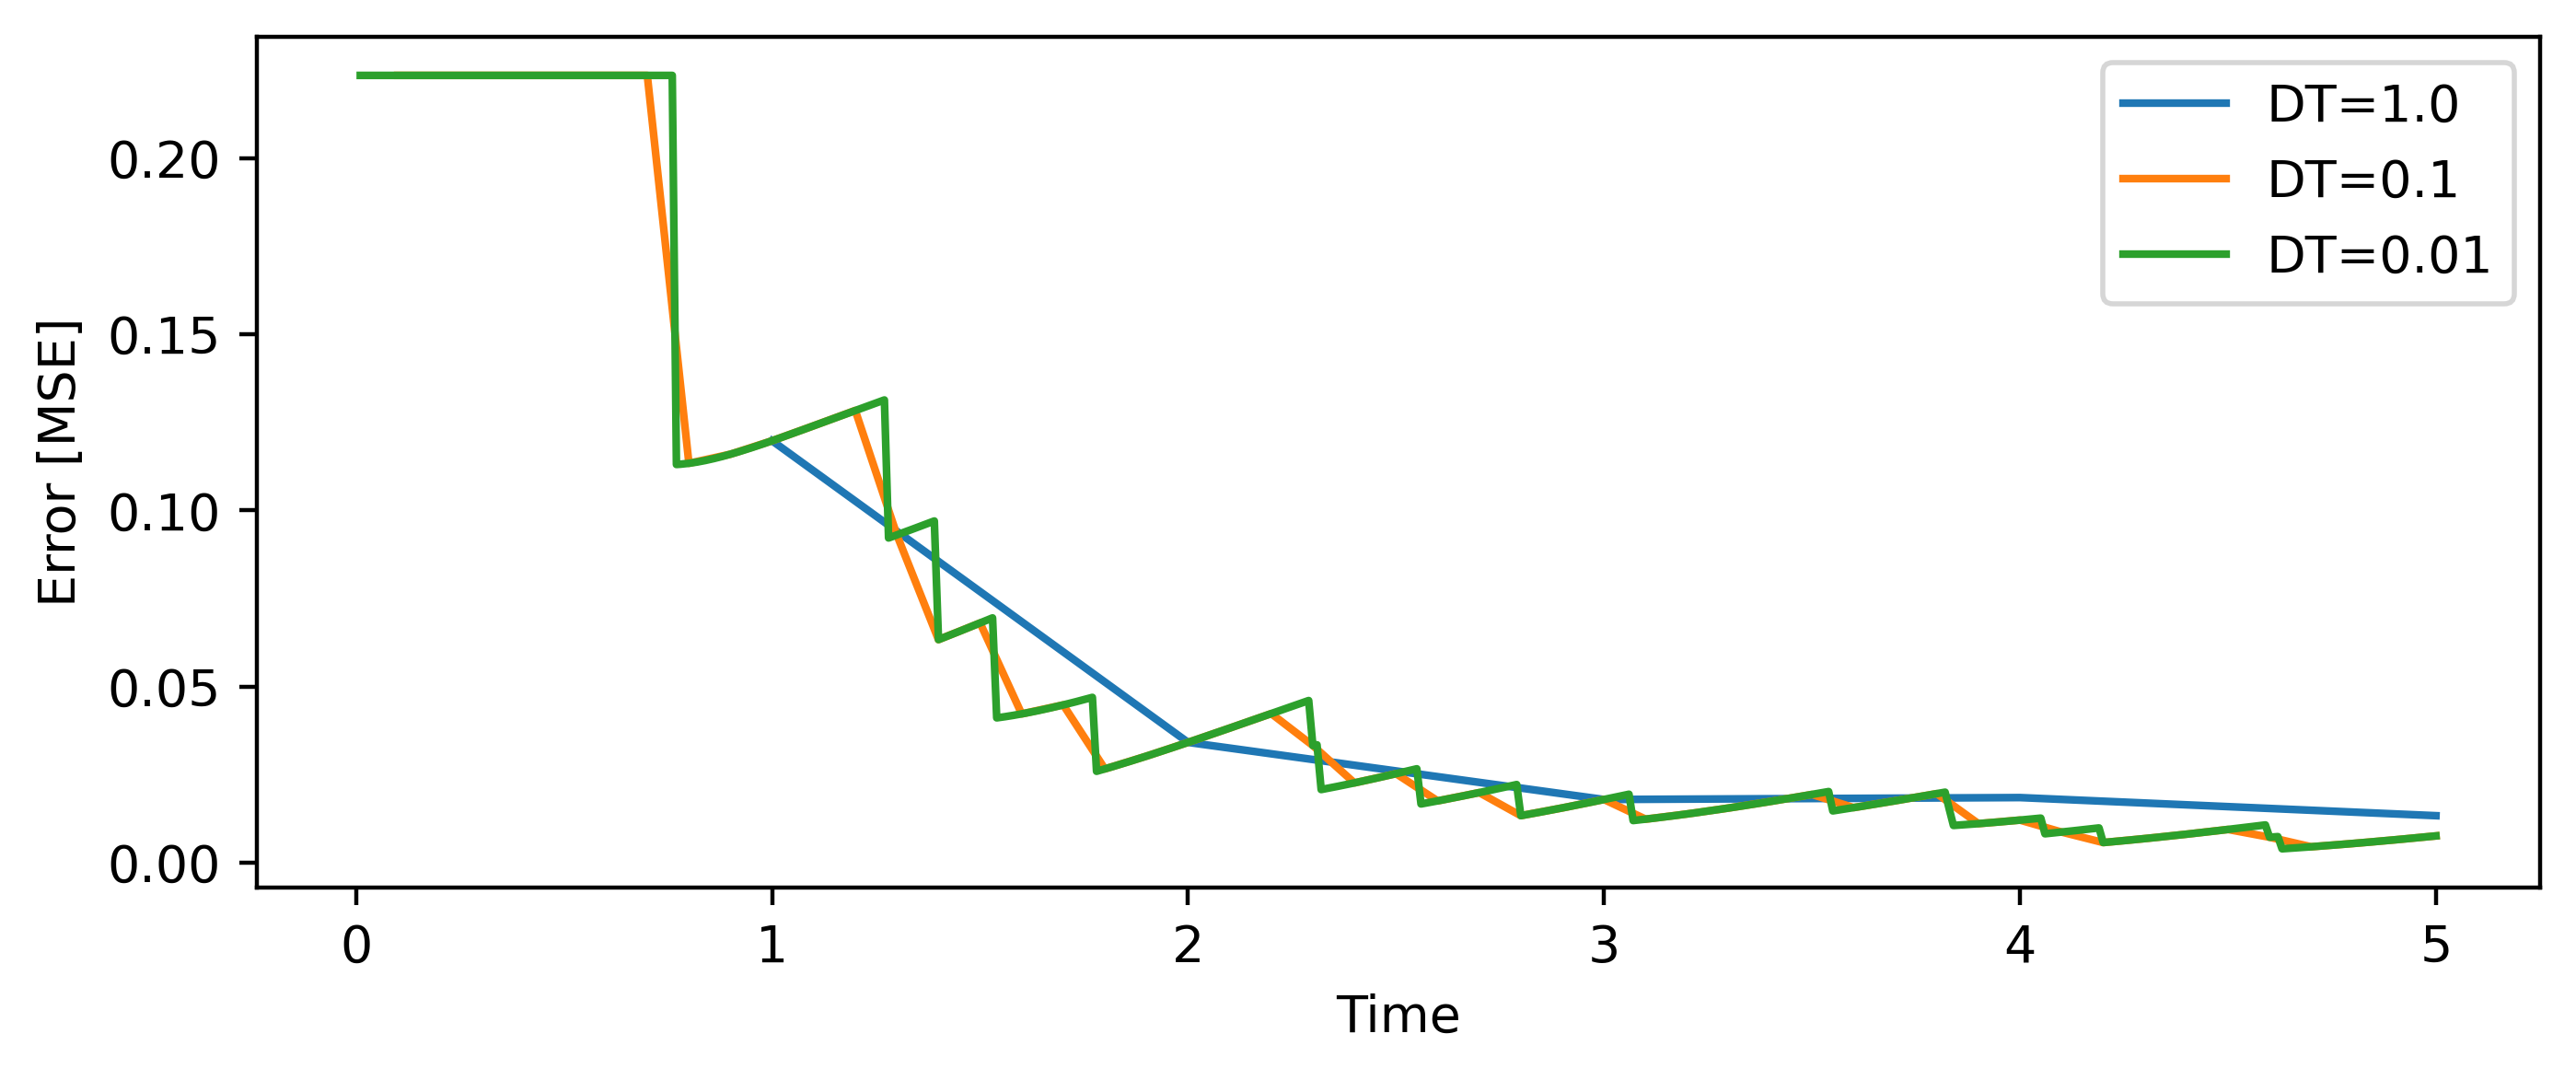

In [7]:
plt.figure(figsize=(8, 3), dpi=400)
for dt in [1.0, 0.1, 0.01]:
	model = make_model()
	model = replace_relu_with_qcfs(model, L=V_T)
	model = replace_qcfs_with_sn(model, TAU, "if", noise=0, dt=dt)
	T = int(5.0 / dt)
	TIME = np.arange(1, T+1) * dt
	loss, _, _ = run_exp(model)
	print(loss[0])
	plt.plot(TIME, loss, label=f'DT={dt}')
plt.ylabel('Error [MSE]')
plt.xlabel('Time')
plt.legend();
